In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit

In [2]:
# class LinearRegression(LinearRegression):
#     """
#     LinearRegression class after sklearn's, but calculate t-statistics
#     and p-values for model coefficients (betas).
#     Additional attributes available after .fit()
#     are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
#     which is (n_features, n_coefs)
#     This class sets the intercept to 0 by default, since usually we include it
#     in X.
#     """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)

#     def fit(self, X, y, n_jobs=1):
#         self = super(LinearRegression, self).fit(X, y, n_jobs)

#         sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X)))) for i in range(sse.shape[0])])

#         self.t = self.coef_ / se
#         self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
#         return self

In [9]:
file_dir = os.listdir('Data/')
file_dir.sort()

participant_num = []
files = []
for file_name in file_dir:
    usecols = ['trial', 'choice1', 'state', 'age', 'won']
    file = pd.read_csv('Data/' + file_name, sep='\t', index_col=0, usecols=usecols, skiprows=lambda x: x in range(3, 11)) # Start analysis at row 10
    file = file[file['choice1'] != 0] # Exclude trails that choice1 was missed
    file = file.dropna()
    files.append(file)
    participant_num.append(file_name[2:7])
    print(file_name)

print(participant_num)
data = pd.concat(files)

SC00001_11-Apr-2019.txt
SC00002_26-Apr-2019.txt
SC00003_18-Jun-2019.txt
SC00004_13-May-2019.txt
SC00006_05-Aug-2019.txt
SC00007_28-Jun-2019.txt
SC00008_19-Jun-2019.txt
SC00009_24-Jun-2019.txt
SC00010_24-Jun-2019.txt
SC00012_19-Jul-2019.txt
SC00013_19-Jul-2019.txt
SC00014_02-Aug-2019.txt
SC00015_29-Jul-2019.txt
SC00016_30-Jul-2019.txt
SC00017_24-Jul-2019.txt
SC00020_23-Jul-2019.txt
SC00021_24-Jul-2019.txt
SC00022_27-Aug-2019.txt
SC00023_06-Sep-2019.txt
SC00024_27-Aug-2019.txt
SC00104_27-Sep-2018.txt
SC00106_27-Sep-2018.txt
SC00108_12-Dec-2018.txt
SC00110_12-Dec-2018.txt
SC00111_12-Dec-2018.txt
SC00112_14-Sep-2019.txt
SC00113_14-Sep-2019.txt
SC00114_29-Mar-2019.txt
SC00115_01-Apr-2019.txt
SC00120_14-May-2019.txt
SC00121_14-May-2019.txt
['00001', '00002', '00003', '00004', '00006', '00007', '00008', '00009', '00010', '00012', '00013', '00014', '00015', '00016', '00017', '00020', '00021', '00022', '00023', '00024', '00104', '00106', '00108', '00110', '00111', '00112', '00113', '00114', '00

In [4]:
# 108	Female	66
# 104	Female	86
# 106	Female	73
# 110	Female	69
# 111	Female	75
# 112	Female	72
# 113	Male	75
# 114	Female	71
# 115	Female	61
# 120	Male	69
# 121	Female	70
# 2	Female	75
# 1	Male	74
# 3	Female	67
# 4	Female	70
# 6	Male	80
# 7	Female	70
# 9	Female	67
# 10	Female	74
# 12	Female	72
# 13	Male	76
# 14	Female	71
# 15	Male	70
# 16	Male	69
# 17	Male	68
# 20	Male	73
# 21	Male	73
# 22	Female	70
# 23	Male	66
# 24	Male	67


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

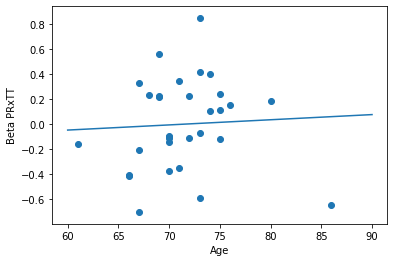

In [5]:
age = np.array([74, 75, 67, 70, 80, 70, 67, 73, 74, 72, 76, 71, 70, 69, 68, 73, 73, 70, 66, 67, 86, 73, 66, 69, 75, 72, 75, 71, 61, 69, 70])
betas = []

for file in files:
    choice1 = file['choice1'] == 1
    choice2 = ~choice1
    state2 = file['state'] == 2
    state3 = ~state2

    state = (choice1 & state2) | (choice2 & state3)
    
    x1 = state[:-1].values[:, None]
    x2 = file['won'][1:].values[:, None]
    x3 = file['age'][1:].values.reshape(-1, 1)
    x4 = x1 * x2
    x5 = x1 * x3
    x6 = x2 * x3
    x7 = x1 * x2 * x3
    y = state[1:].values

    x = np.concatenate([x1, x2, x4], axis=1)

    lr = LogisticRegression()
    lr.fit(x, y)
    
    betas.append(lr.coef_[0, 2])

lr2 = LinearRegression()
# betas = np.square(np.array(betas))
lr2.fit(age[:, None], betas)

x_test = np.linspace(60, 90, 300)[:, None]

loss = (x_test * lr2.coef_ + lr2.intercept_).ravel()
    
plt.scatter(age, betas)
plt.plot(x_test, loss)
plt.xlabel('Age')
plt.ylabel('Beta PRxTT')
plt.show()

In [17]:
values = [age, betas]
betas_file = pd.DataFrame(betas, participant_num, columns=['Age', 'Betas'])
betas_file.to_excel('Participant_Betas.xlsx')

In [4]:
choice1 = data['choice1'] == 1
choice2 = ~choice1
state2 = data['state'] == 2
state3 = ~state2

state = (choice1 & state2) | (choice2 & state3)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


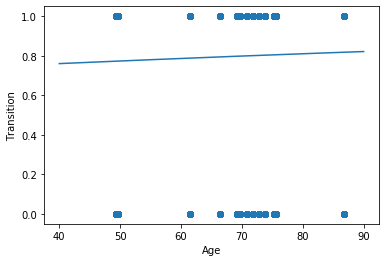

In [40]:
x1 = state[:-1].values[:, None]
x2 = data['won'][1:].values[:, None]
x3 = data['age'][1:].values.reshape(-1, 1)
x4 = x1 * x2
x5 = x1 * x3
x6 = x2 * x3
x7 = x1 * x2 * x3
y = state[1:].values

x = np.concatenate([x1, x2, x4], axis=1)

lr = LogisticRegression()
lr.fit(x, y)

x_test = np.linspace(40, 90, 300)[:, None]

loss = expit((x_test * lr.coef_[0, None])[:, 0] + lr.intercept_).ravel()

plt.plot(x_test, loss)
plt.scatter(x3, x4)
plt.xlabel('Age')
plt.ylabel('Transition')
plt.show()

In [38]:
lr.intercept_, lr.coef_

(array([0.85920471]), array([[ 0.00745897, -0.14430516,  0.12184811]]))